# Estimating COVID-19's $R_t$ in Real-Time

This notebook reproduces the estimate of the time-varying reproductive number $R_t$ implemented by [Kevin Systrom](https://twitter.com/kevin) available [here](https://github.com/k-sys/covid-19).

Here, I am applying the same code to the Italian case data at _subnational level (Regions and Provinces)_, with minor changes:
* a different assumed average serial interval (6.6 days) 
* a shift of 14 days of the time-series to take into account the reporting delays

For clarity, I have removed all the text from the original notebook, which describes the theory behind the method. 

The [original paper can be used as reference](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0002185).

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output

%config InlineBackend.figure_format = 'retina'

In [2]:
# Column vector of k
k = np.arange(0, 70)[:, None]

# Different values of Lambda
lambdas = [10, 20, 30, 40]

# Evaluated the Probability Mass Function (remember: poisson is discrete)
y = sps.poisson.pmf(k, lambdas)

# Show the resulting shape
print(y.shape)

(70, 4)


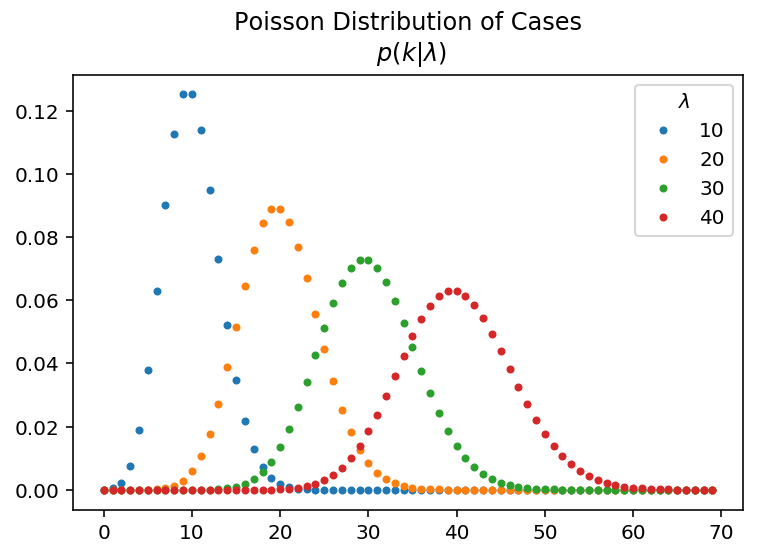

In [3]:
fig, ax = plt.subplots()

ax.set(title='Poisson Distribution of Cases\n $p(k|\lambda)$')

plt.plot(k, y,
         marker='o',
         markersize=3,
         lw=0)

plt.legend(title="$\lambda$", labels=lambdas);

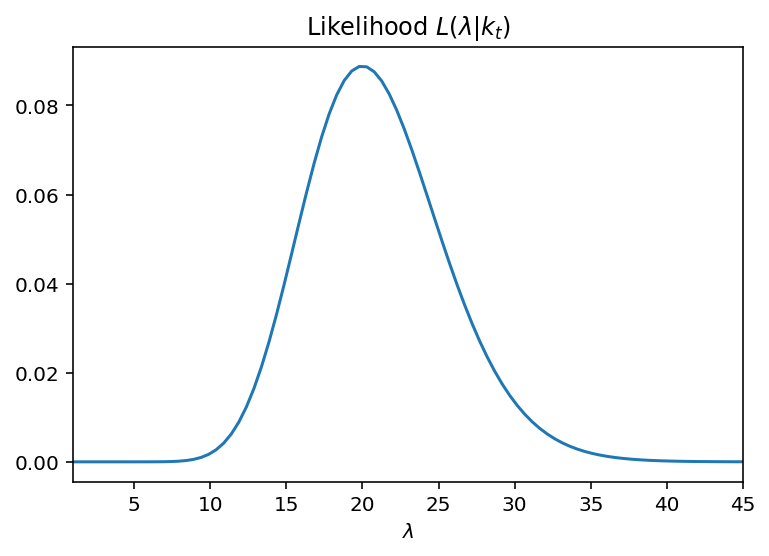

In [4]:
k = 20

lam = np.linspace(1, 45, 90)

likelihood = pd.Series(data=sps.poisson.pmf(k, lam),
                       index=pd.Index(lam, name='$\lambda$'),
                       name='lambda')

likelihood.plot(title=r'Likelihood $L\left(\lambda|k_t\right)$');

# Parameters
We don't consider values of $R_t$ larger than 8 and we assume an average serial interval equal to 6.6 days as reported in [the literature for Italian cases](https://arxiv.org/abs/2003.09320)

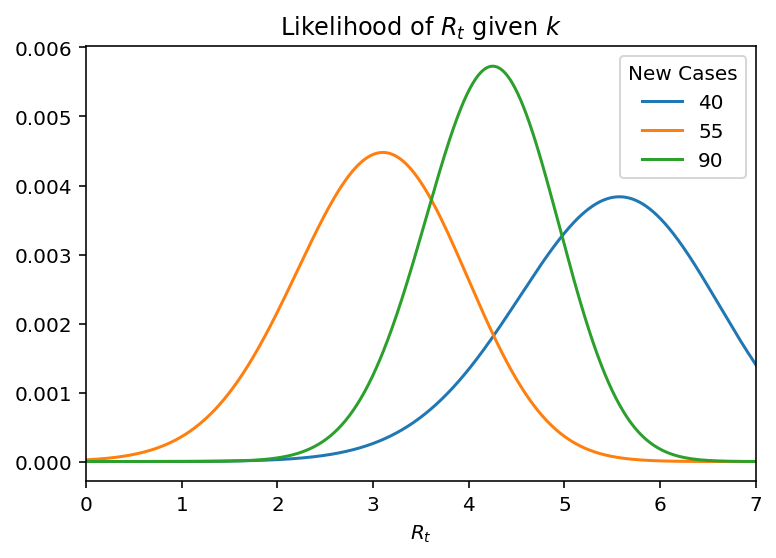

In [5]:
k = np.array([20, 40, 55, 90])

# We create an array for every possible value of Rt
R_T_MAX = 8
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

# Gamma is 1/serial interval
# paper by Marco and Stefano
GAMMA = 1/6.6

# Map Rt into lambda so we can substitute it into the equation below
# Note that we have N-1 lambdas because on the first day of an outbreak
# you do not know what to expect.
lam = k[:-1] * np.exp(GAMMA * (r_t_range[:, None] - 1))

# Evaluate the likelihood on each day and normalize sum of each day to 1.0
likelihood_r_t = sps.poisson.pmf(k[1:], lam)
likelihood_r_t /= np.sum(likelihood_r_t, axis=0)

# Plot it
ax = pd.DataFrame(
    data = likelihood_r_t,
    index = r_t_range
).plot(
    title='Likelihood of $R_t$ given $k$',
    xlim=(0,7)
)

ax.legend(labels=k[1:], title='New Cases')
ax.set_xlabel('$R_t$');

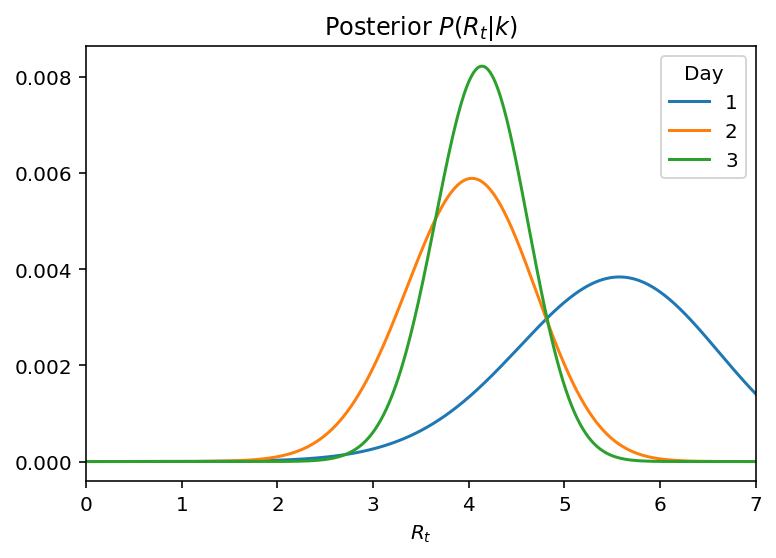

In [6]:
posteriors = likelihood_r_t.cumprod(axis=1)
posteriors = posteriors / np.sum(posteriors, axis=0)

columns = pd.Index(range(1, posteriors.shape[1]+1), name='Day')
posteriors = pd.DataFrame(
    data = posteriors,
    index = r_t_range,
    columns = columns)

ax = posteriors.plot(
    title='Posterior $P(R_t|k)$',
    xlim=(0,7)
)
ax.legend(title='Day')
ax.set_xlabel('$R_t$');

In [7]:
most_likely_values = posteriors.idxmax(axis=0)

In [8]:
def highest_density_interval(pmf, p=.95):
    
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col]) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    best = None
    for i, value in enumerate(cumsum):
        for j, high_value in enumerate(cumsum[i+1:]):
            if (high_value-value > p) and (not best or j<best[1]-best[0]):
                best = (i, i+j+1)
                break
            
    low = pmf.index[best[0]]
    high = pmf.index[best[1]]
    return pd.Series([low, high], index=['Low', 'High'])

hdi = highest_density_interval(posteriors, p=.95)

# Real-World Application to Italian data

### Setup

Load the Italian case count data from the public repo of the Protezione Civile

In [9]:
url = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv'
states = pd.read_csv(url,
                     usecols=[0,3,15],
                     index_col=['denominazione_regione', 'data'],
                     parse_dates=['data'],
                     squeeze=True).sort_index()

## Time shift to account for the reporting delay

We add a constant offset to the case notification data of 14 days to take into account the delay from contagion to reporting.
This is clearly a very rough assumption and other statistical methods to assign a date of infection to all cases would provide a better estimate.

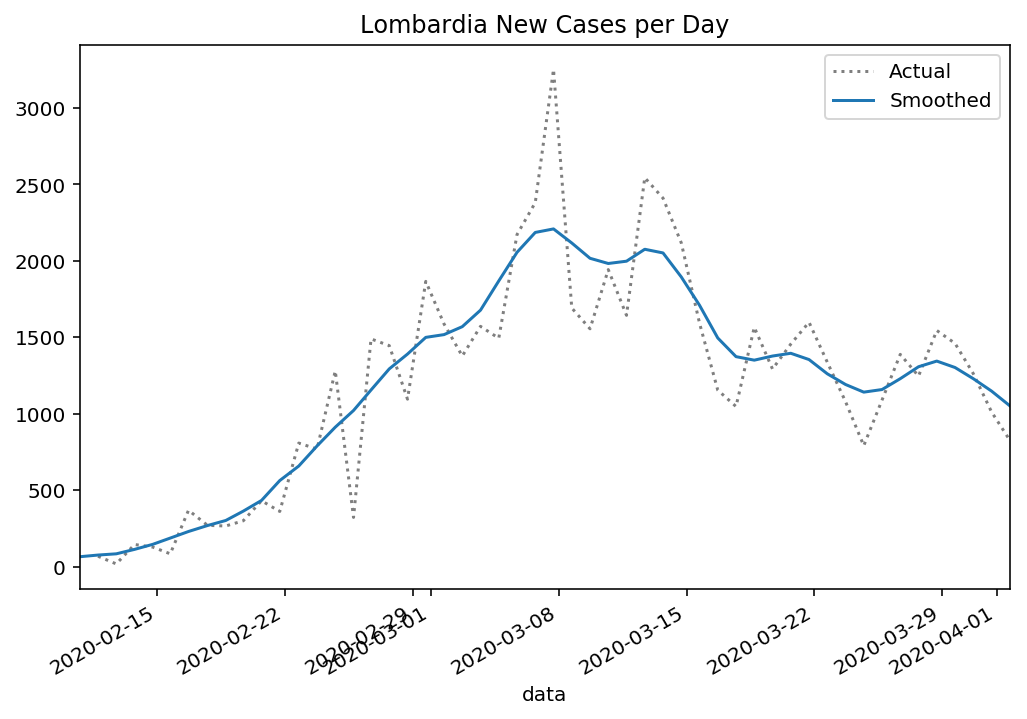

In [10]:
state_name = 'Lombardia'

def prepare_cases(cases):

    cases=cases.shift(-14, freq='D')
    
    new_cases = cases.diff()

    smoothed = new_cases.rolling(7,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=2).round()
    
    zeros = smoothed.index[smoothed.eq(0)]
    if len(zeros) == 0:
        idx_start = 0
    else:
        last_zero = zeros.max()
        idx_start = smoothed.index.get_loc(last_zero) + 1
    smoothed = smoothed.iloc[idx_start:]
    original = new_cases.loc[smoothed.index]
    
    return original, smoothed

cases = states.xs(state_name).rename(f"{state_name} cases")

original, smoothed = prepare_cases(cases)

original.plot(title=f"{state_name} New Cases per Day",
               c='k',
               linestyle=':',
               alpha=.5,
               label='Actual',
               legend=True,
             figsize=(600/72, 400/72))

ax = smoothed.plot(label='Smoothed',
                   legend=True)
ax.get_figure().set_facecolor('w')

In [11]:
def get_posteriors(sr, window=7, min_periods=1):
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))

    # Note: if you want to have a Uniform prior you can use the following line instead.
    # I chose the gamma distribution because of our prior knowledge of the likely value
    # of R_t.
    
    # prior0 = np.full(len(r_t_range), np.log(1/len(r_t_range)))
    prior0 = np.log(sps.gamma(a=3).pdf(r_t_range) + 1e-14)

    likelihoods = pd.DataFrame(
        # Short-hand way of concatenating the prior and likelihoods
        data = np.c_[prior0, sps.poisson.logpmf(sr[1:].values, lam)],
        index = r_t_range,
        columns = sr.index)

    # Perform a rolling sum of log likelihoods. This is the equivalent
    # of multiplying the original distributions. Exponentiate to move
    # out of log.
    posteriors = likelihoods.rolling(window,
                                     axis=1,
                                     min_periods=min_periods).sum()
    posteriors = np.exp(posteriors)

    # Normalize to 1.0
    posteriors = posteriors.div(posteriors.sum(axis=0), axis=1)
    
    return posteriors

posteriors = get_posteriors(smoothed)

### The Result


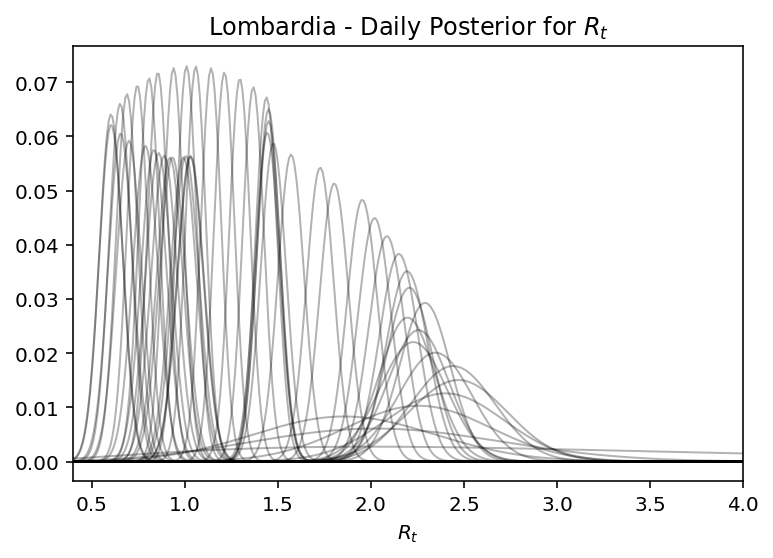

In [12]:
ax = posteriors.plot(title=f'{state_name} - Daily Posterior for $R_t$',
           legend=False, 
           lw=1,
           c='k',
           alpha=.3,
           xlim=(0.4,4))

ax.set_xlabel('$R_t$');

### Plotting in the Time Domain with Credible Intervals

In [13]:
# Note that this takes a while to execute - it's not the most efficient algorithm
hdis = highest_density_interval(posteriors)

most_likely = posteriors.idxmax().rename('ML')

# Look into why you shift -1
result = pd.concat([most_likely, hdis], axis=1)

result.tail()

,ML,Low,High
data,,,
2020-03-28 17:00:00,0.99,0.85,1.13
2020-03-29 17:00:00,1.03,0.89,1.17
2020-03-30 17:00:00,1.03,0.89,1.17
2020-03-31 17:00:00,1.01,0.87,1.15
2020-04-01 17:00:00,0.92,0.78,1.06


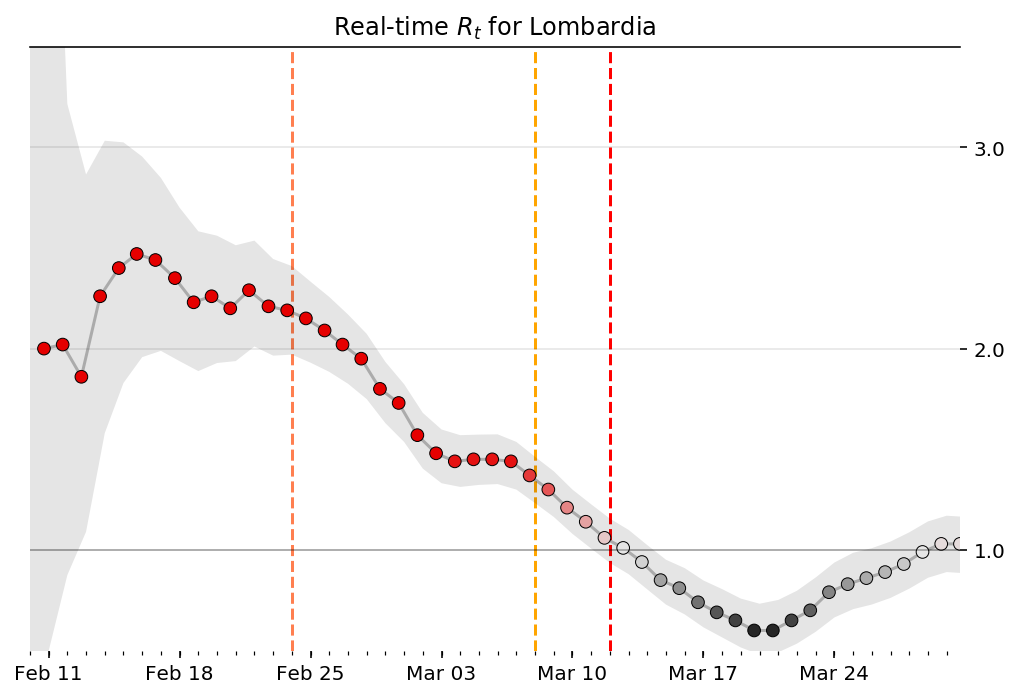

In [14]:
def plot_rt(result, ax, state_name):
    
    ax.set_title(f"{state_name}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('data')
    values = result['ML'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    ax.axvline('2020-02-24', ls='--', color='coral', lw=1.5, zorder=0)
    ax.axvline('2020-03-08', ls='--', color='orange', lw=1.5, zorder=0)
    ax.axvline('2020-03-12', ls='--', color='red', lw=1.5, zorder=0)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                    result['Low'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                     result['High'].values,
                     bounds_error=False,
                    fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-02-10'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0,3.5)
    ax.set_xlim(pd.Timestamp('2020-02-10'), result[:-3].index.get_level_values('data')[-1]+pd.Timedelta(days=1))
    fig.set_facecolor('w')

    
fig, ax = plt.subplots(figsize=(600/72,400/72))

plot_rt(result, ax, state_name)
ax.set_title(f'Real-time $R_t$ for {state_name}')
ax.set_ylim(.5,3.5)
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

### Repeat the Process for Every Region

In [15]:
FILTERED_REGIONS=[]

results = {}

states_to_process = states.loc[~states.index.get_level_values('denominazione_regione').isin(FILTERED_REGIONS)]

for state_name, cases in states_to_process.groupby(level='denominazione_regione'):
        
    clear_output(wait=True)
    print(f'Processing {state_name}')
    
    cases=cases.droplevel(0)
    new, smoothed = prepare_cases(cases)
    print('\tGetting Posteriors')
    try:
        posteriors = get_posteriors(smoothed)
    except:
        display(cases)
    print('\tGetting HDIs')
    hdis = highest_density_interval(posteriors)
    print('\tGetting most likely values')
    most_likely = posteriors.idxmax().rename('ML')
    result = pd.concat([most_likely, hdis], axis=1)
    results[state_name] = result
    #.droplevel(0)
    
clear_output(wait=True)
print('Done.')

Done.


### Plot all the Regions

In [16]:
today=str(pd.to_datetime('today').date())

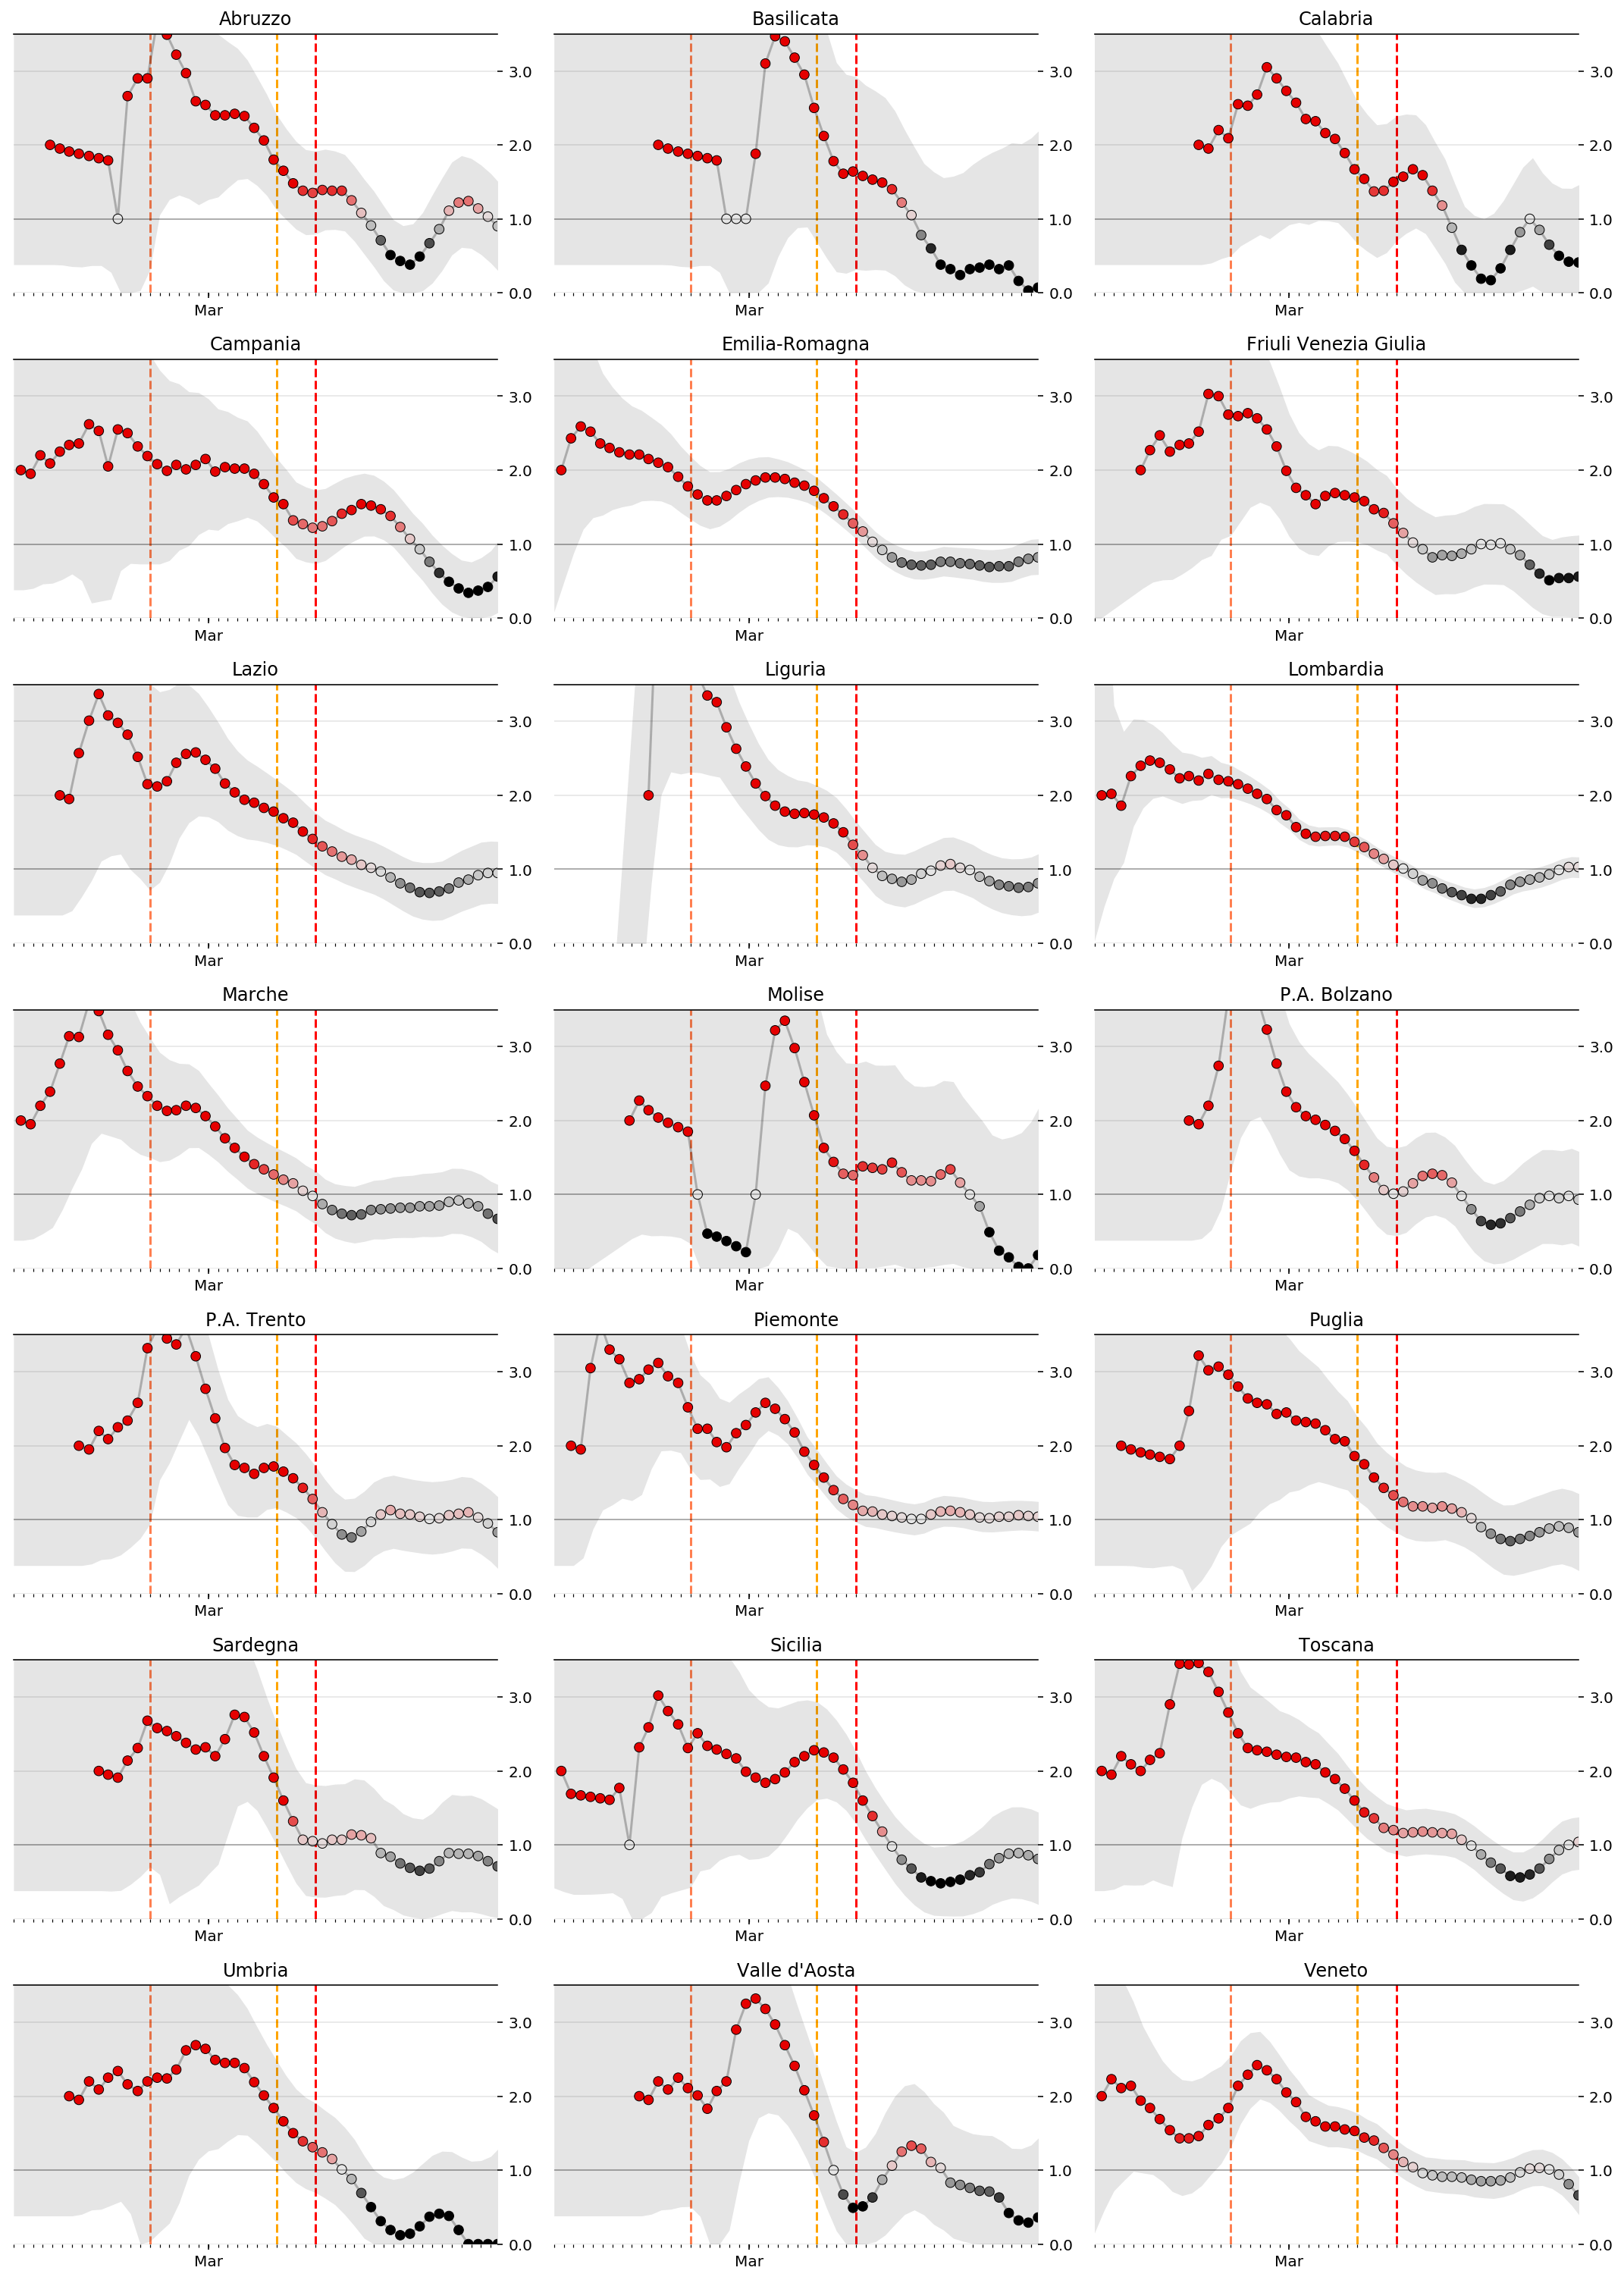

In [17]:
ncols = 3
nrows = int(np.ceil(len(results) / ncols))

# fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))

for i, (state_name, result) in enumerate(results.items()):
    plot_rt(result, axes.flat[i], state_name)

fig.tight_layout()
fig.set_facecolor('w')

plt.savefig('./Figures/Rt_Italian_regions_summary_'+today+'.png')

In [18]:
overall = None

for state_name, result in results.items():
    r = result.copy()
    r.index = pd.MultiIndex.from_product([[state_name], result.index])
    if overall is None:
        overall = r
    else:
        overall = pd.concat([overall, r])

overall.sort_index(inplace=True)

FULL_COLOR = [.7,.7,.7]
NONE_COLOR = [179/255,35/255,14/255]
PARTIAL_COLOR = [.5,.5,.5]
ERROR_BAR_COLOR = [.3,.3,.3]

In [19]:
overall

ML   Low  High
Abruzzo 2020-02-13 18:00:00  2.00  0.38  6.14
        2020-02-14 18:00:00  1.95  0.38  5.71
        2020-02-15 17:00:00  1.91  0.36  5.34
        2020-02-16 17:00:00  1.88  0.34  5.04
        2020-02-17 18:00:00  1.85  0.37  4.85
...                           ...   ...   ...
Veneto  2020-03-28 17:00:00  0.94  0.70  1.19
        2020-03-29 17:00:00  0.81  0.57  1.07
        2020-03-30 17:00:00  0.66  0.41  0.92
        2020-03-31 17:00:00  0.48  0.22  0.75
        2020-04-01 17:00:00  0.33  0.07  0.61

[1006 rows x 3 columns]

In [20]:
import seaborn as sns

(<Figure size 1080x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12b69fe48>)

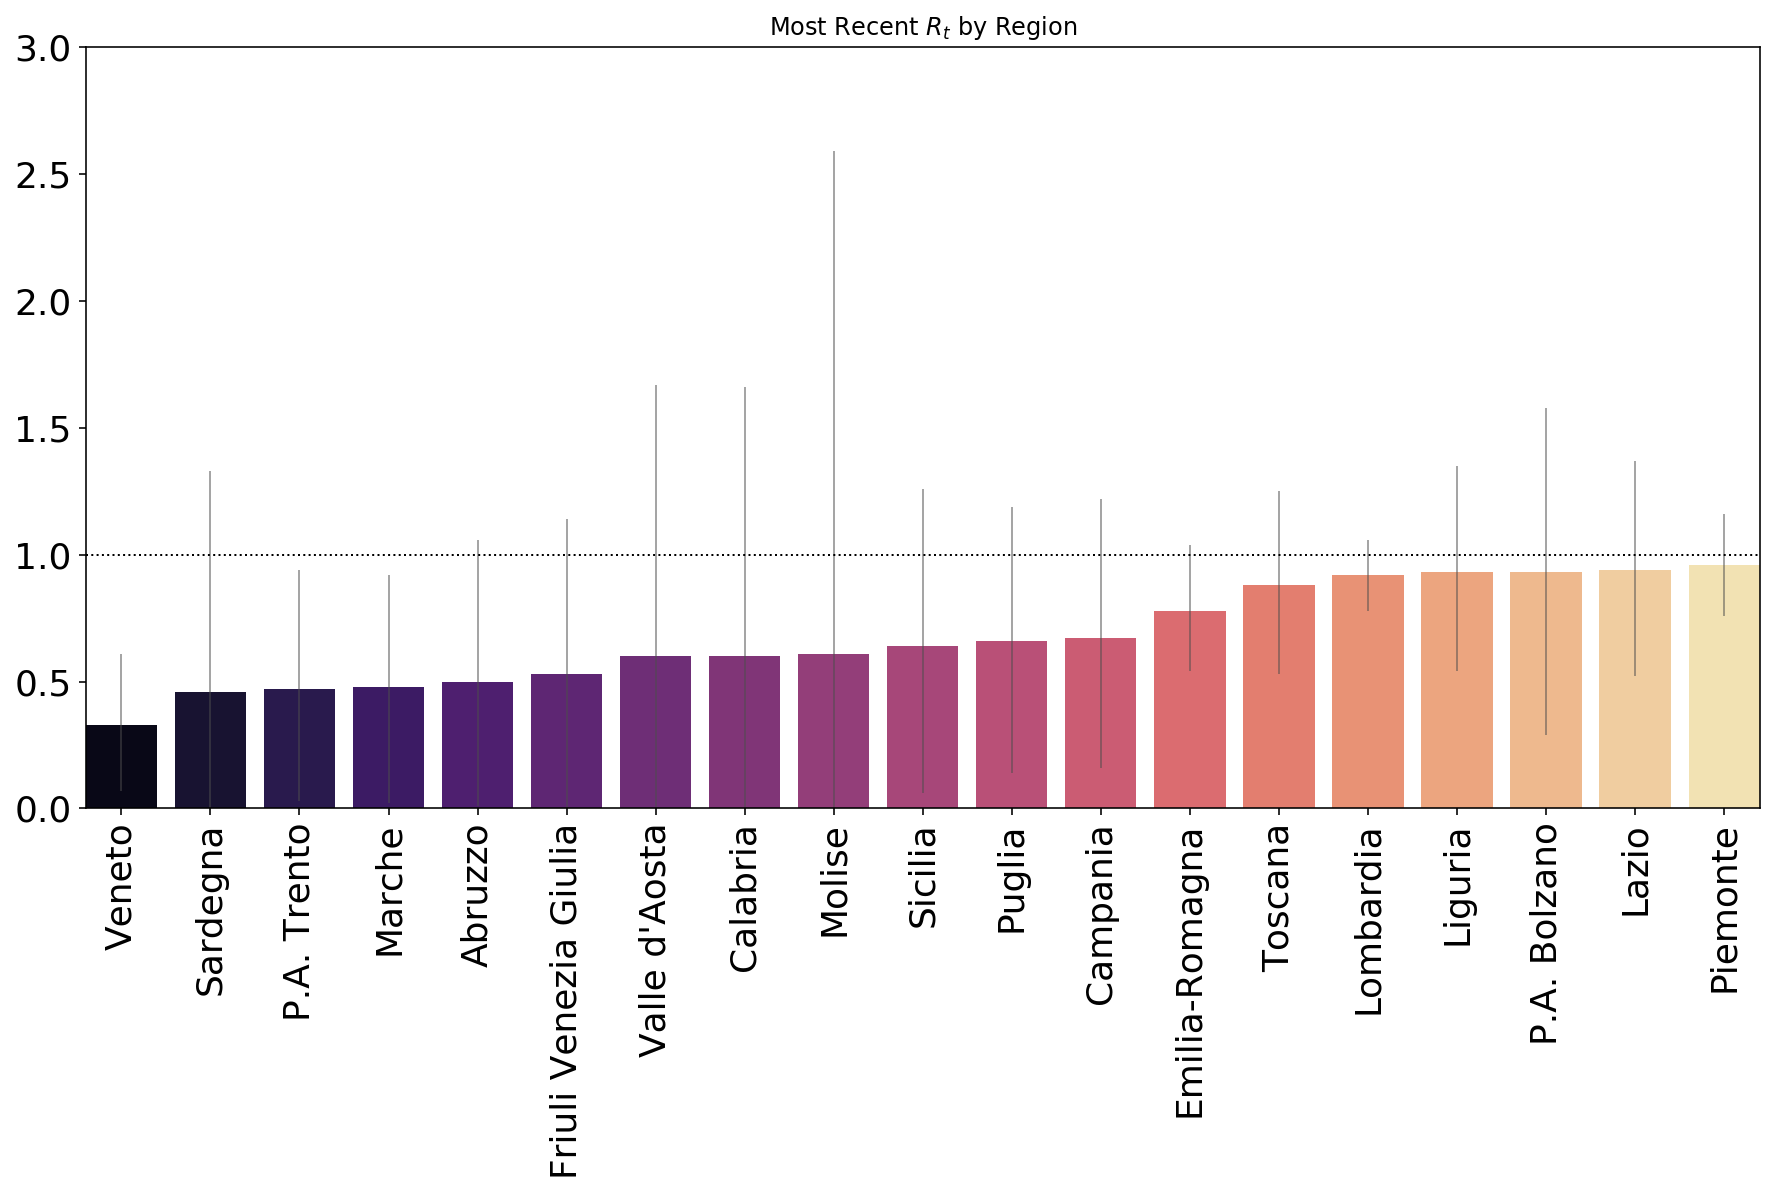

In [43]:
filtered = overall.index.get_level_values(0).isin(FILTERED_REGIONS)
mr = overall.loc[~filtered].groupby(level=0)[['ML', 'High', 'Low']].last()

mr=mr[mr['ML']>0]

def plot_standings(mr, figsize=None, title='Most Recent $R_t$ by Region', fontsize=14):
    #if not figsize:
    #    figsize = ((15.9/50)*len(mr)+.1,2.5)
        
    fig, ax = plt.subplots(figsize=(15,7))

    ax.set_title(title)
    err = mr[['Low', 'High']].sub(mr['ML'], axis=0).abs()
    bars = sns.barplot(mr.index,
                  mr['ML'],
                  #width=.825,
                  #color=mr.ML.values,
                  ecolor=ERROR_BAR_COLOR,
                  palette='magma',
    
                  capsize=2,
                  error_kw={'alpha':.5, 'lw':1},
                  yerr=err.values.T)

    #for bar, state_name in zip(bars, mr.index):
    #    if state_name in no_lockdown:
    #        bar.set_color(NONE_COLOR)
    #    if state_name in partial_lockdown:
    #        bar.set_color(PARTIAL_COLOR)

    labels = mr.index.to_series()
    ax.set_xticklabels(labels, rotation=90, fontsize=11)
    ax.margins(0)
    ax.set_ylim(0,3)
    plt.yticks(fontsize=18)
    plt.ylabel("")
    ax.axhline(1.0, linestyle=':', color='k', lw=1)
    ax.set_xticklabels(labels, fontsize=18)


    #leg = ax.legend(handles=[
    #                    Patch(label='Full', color=FULL_COLOR),
    #                    Patch(label='Partial', color=PARTIAL_COLOR),
    #                    Patch(label='None', color=NONE_COLOR)
    #                ],
    #                title='Lockdown',
    #                ncol=3,
    #                loc='upper left',
    #                columnspacing=.75,
    #                handletextpad=.5,
    #                handlelength=1)

    #leg._legend_box.align = "left"
    #fig.set_facecolor('w')
    plt.savefig('./Figures/Rt_Italian_regions_standings_'+today+'.png', bbox_inches='tight')
    return fig, ax

mr.sort_values('ML', inplace=True)
plot_standings(mr)


# Provinces

Beware! Data at the province level are very noisy. The analysis is purely illustrative. Results may be affected by significant errors at this resolution.

In [23]:
url = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-province/dpc-covid19-ita-province.csv'
states = pd.read_csv(url,
                     usecols=[0,3,6,9],
                     index_col=['denominazione_regione','sigla_provincia', 'data'],
                     parse_dates=['data'],
                     squeeze=True).sort_index()

# Select a region and compute R for all provinces of that region

In [24]:
region_name='Veneto'
region=states[region_name]

In [25]:
region

sigla_provincia  data               
BL               2020-02-24 18:00:00      0
                 2020-02-25 18:00:00      0
                 2020-02-26 18:00:00      0
                 2020-02-27 18:00:00      0
                 2020-02-28 18:00:00      0
                                       ... 
NaN              2020-04-11 17:00:00    324
                 2020-04-12 17:00:00    333
                 2020-04-13 17:00:00    338
                 2020-04-14 17:00:00    339
                 2020-04-15 17:00:00    329
Name: totale_casi, Length: 416, dtype: int64

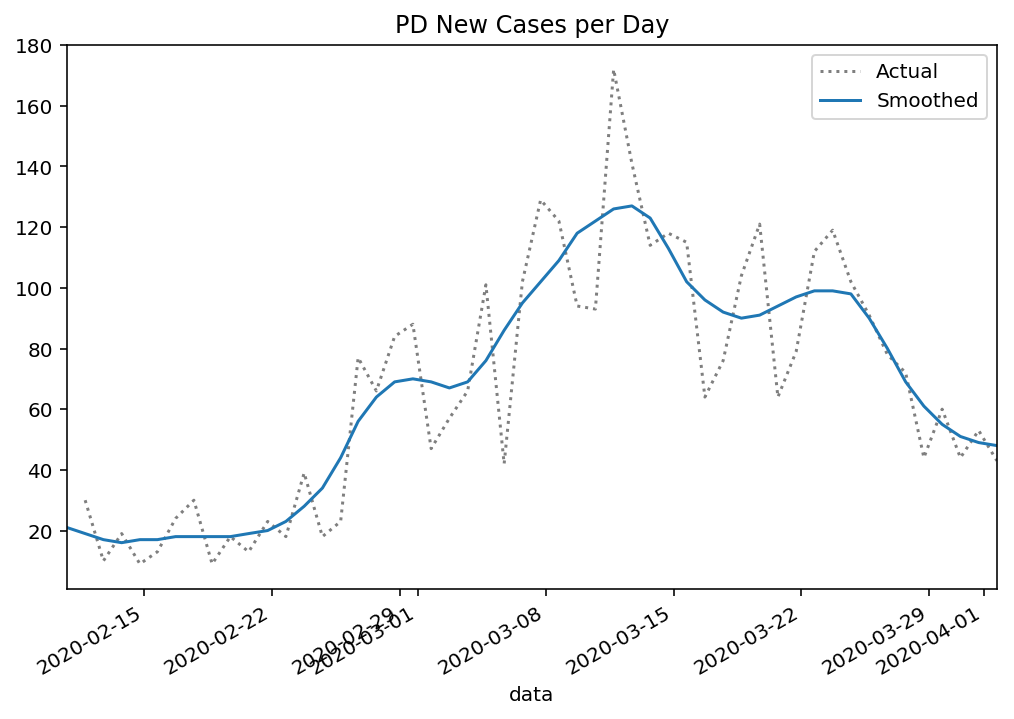

In [26]:
state_name='PD'

cases = region.xs(state_name).rename(f"{state_name} cases")

original, smoothed = prepare_cases(cases)

original.plot(title=f"{state_name} New Cases per Day",
               c='k',
               linestyle=':',
               alpha=.5,
               label='Actual',
               legend=True,
             figsize=(600/72, 400/72))

ax = smoothed.plot(label='Smoothed',
                   legend=True)
ax.get_figure().set_facecolor('w')

In [27]:
posteriors = get_posteriors(smoothed)

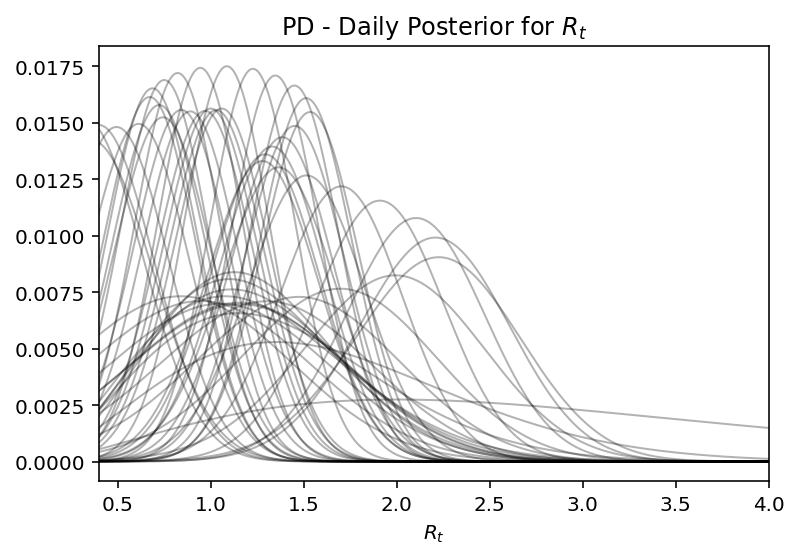

In [28]:
ax = posteriors.plot(title=f'{state_name} - Daily Posterior for $R_t$',
           legend=False, 
           lw=1,
           c='k',
           alpha=.3,
           xlim=(0.4,4))

ax.set_xlabel('$R_t$');

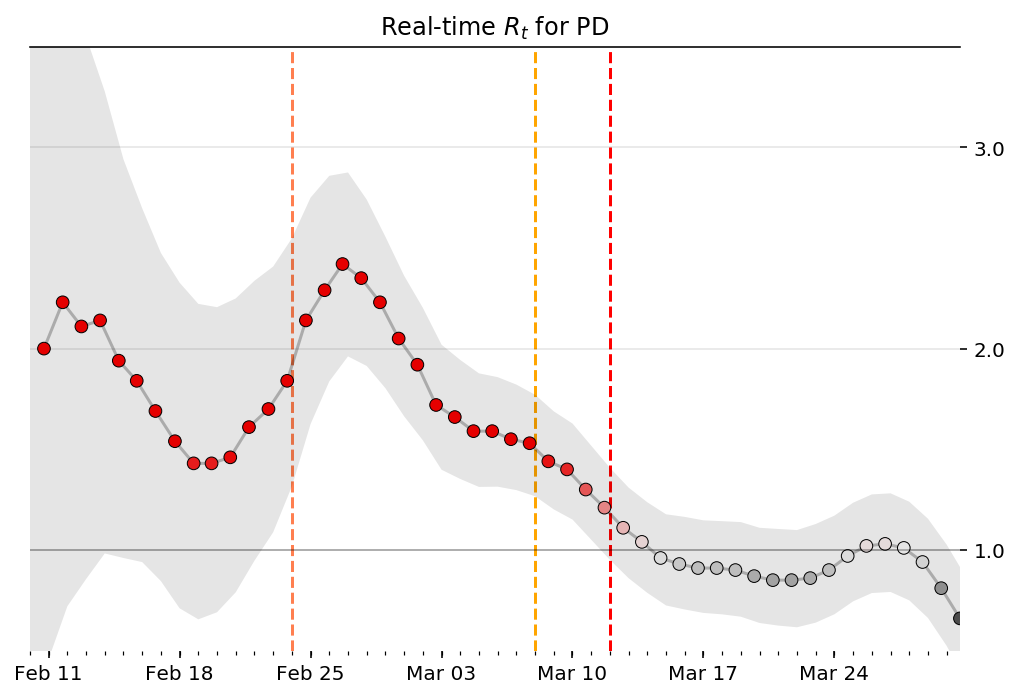

In [29]:
fig, ax = plt.subplots(figsize=(600/72,400/72))

plot_rt(result, ax, state_name)
ax.set_title(f'Real-time $R_t$ for {state_name}')
ax.set_ylim(.5,3.5)
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

In [30]:
results = {}

states_to_process = region.loc[~region.index.get_level_values('sigla_provincia').isin(FILTERED_REGIONS)]

for state_name, cases in states_to_process.groupby(level='sigla_provincia'):
    clear_output(wait=True)
    print(f'Processing {state_name}')
    
    cases=cases.droplevel(0)

    new, smoothed = prepare_cases(cases)
    print('\tGetting Posteriors')
    try:
        posteriors = get_posteriors(smoothed)
    except:
        display(cases)
    print('\tGetting HDIs')
    hdis = highest_density_interval(posteriors)
    print('\tGetting most likely values')
    most_likely = posteriors.idxmax().rename('ML')
    result = pd.concat([most_likely, hdis], axis=1)
    results[state_name] = result
    #.droplevel(0)
    
clear_output(wait=True)
print('Done.')

Done.


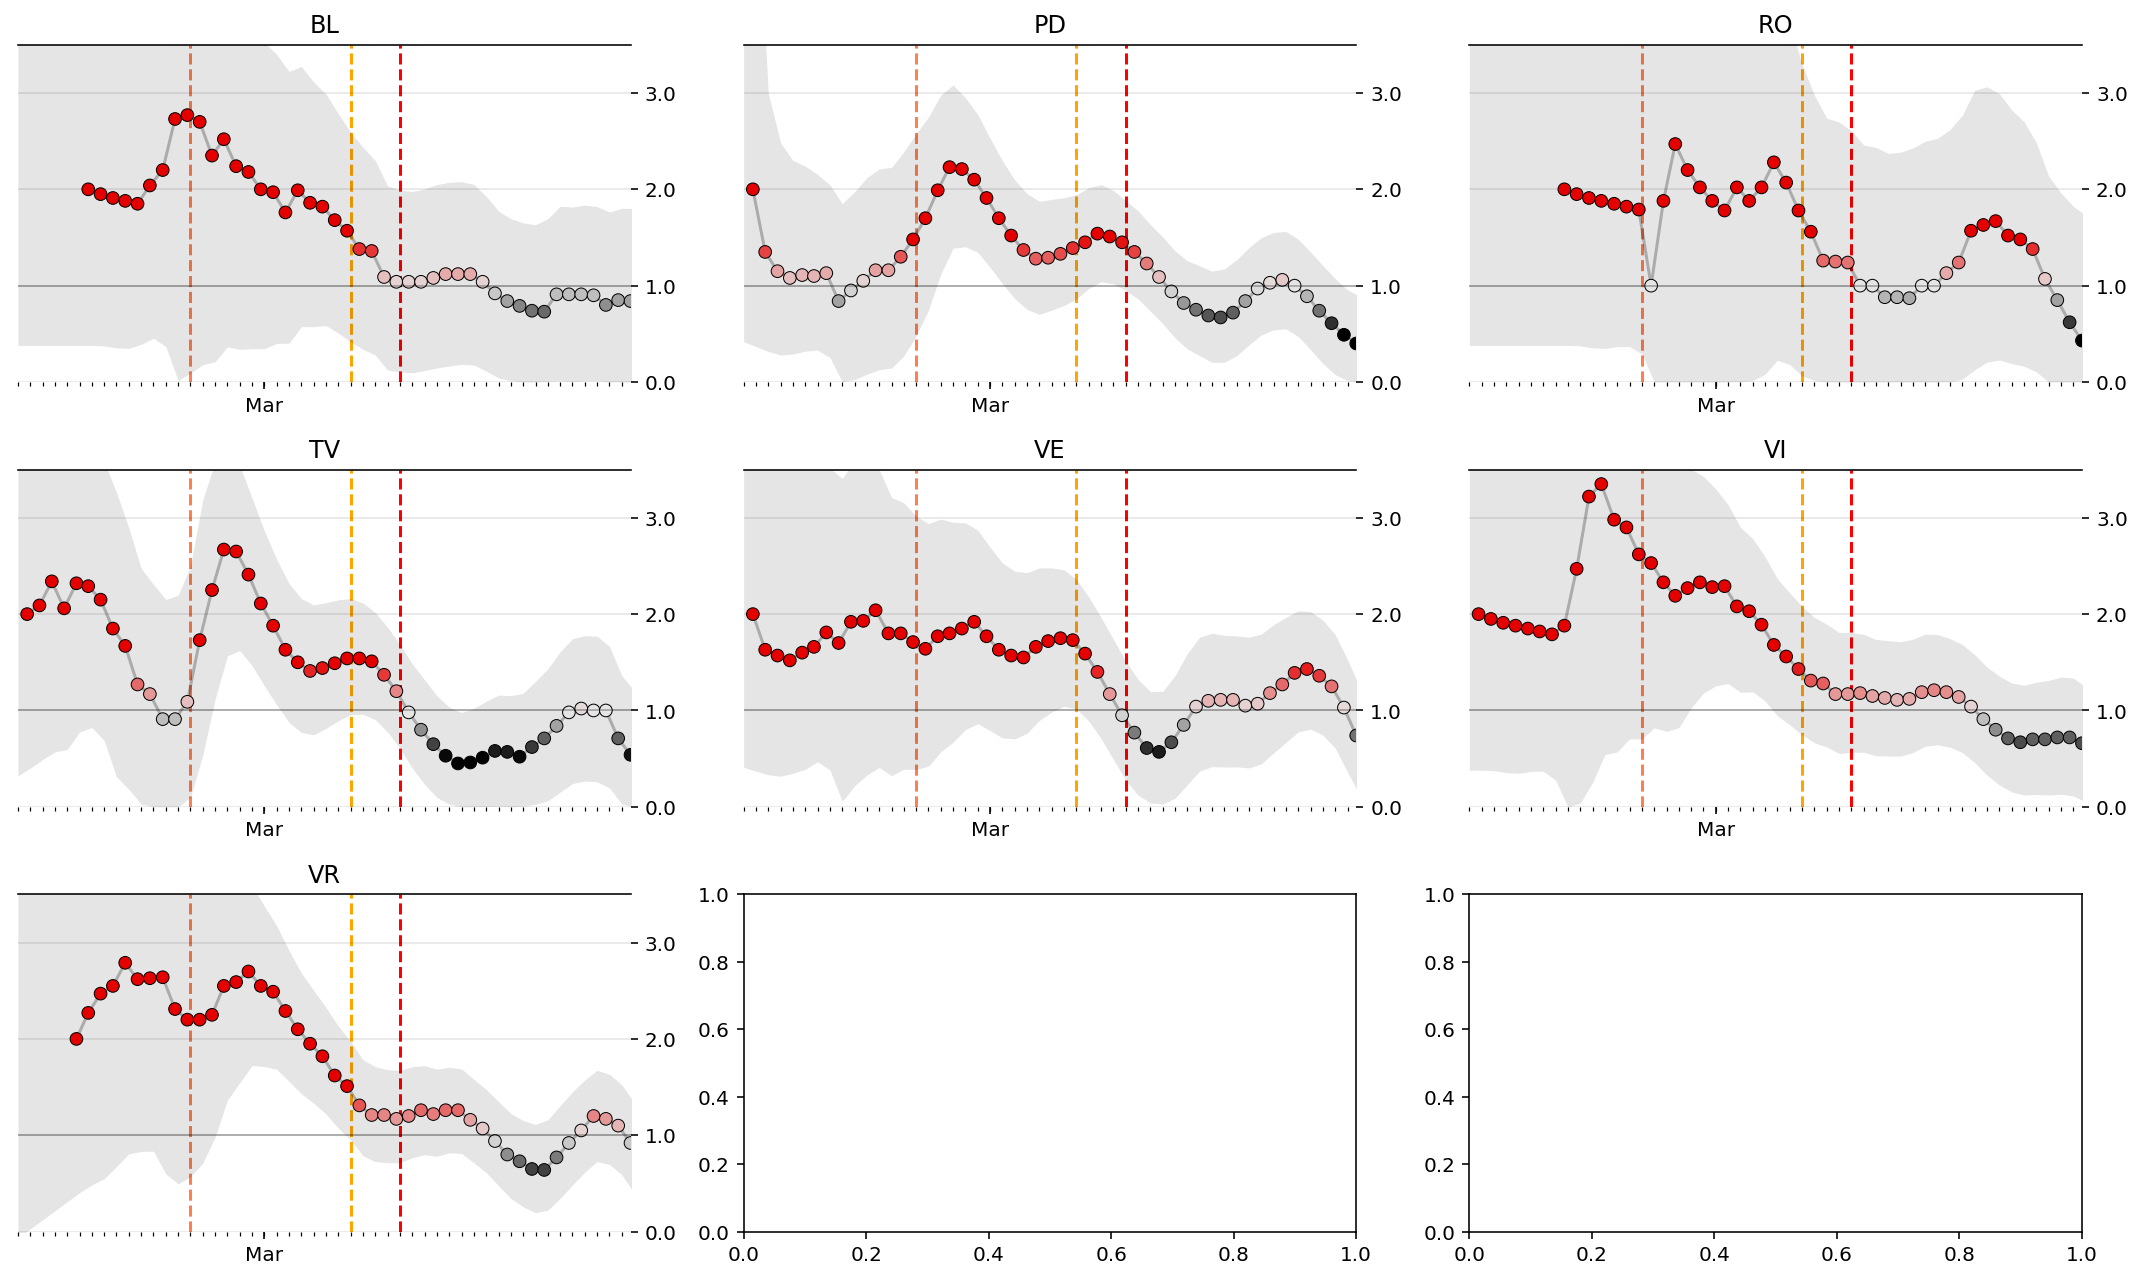

In [31]:
ncols = 3
nrows = int(np.ceil(len(results) / ncols))

# fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))

for i, (state_name, result) in enumerate(results.items()):
    plot_rt(result, axes.flat[i], state_name)

fig.tight_layout()
fig.set_facecolor('w')

plt.savefig('./Figures/Rt_'+region_name+'_provinces_'+today+'.png')